开始训练...
Epoch 1: Train Loss: 0.3737, Acc: 0.888 | Test Acc: 0.949 | LR: 0.25000
Epoch 2: Train Loss: 0.1431, Acc: 0.958 | Test Acc: 0.962 | LR: 0.25000
Epoch 3: Train Loss: 0.0996, Acc: 0.971 | Test Acc: 0.971 | LR: 0.25000
Epoch 4: Train Loss: 0.0767, Acc: 0.978 | Test Acc: 0.972 | LR: 0.25000
Epoch 5: Train Loss: 0.0614, Acc: 0.982 | Test Acc: 0.976 | LR: 0.25000
Epoch 6: Train Loss: 0.0505, Acc: 0.986 | Test Acc: 0.977 | LR: 0.25000
Epoch 7: Train Loss: 0.0423, Acc: 0.988 | Test Acc: 0.970 | LR: 0.25000
Epoch 8: Train Loss: 0.0356, Acc: 0.990 | Test Acc: 0.976 | LR: 0.25000
Epoch 9: Train Loss: 0.0298, Acc: 0.992 | Test Acc: 0.976 | LR: 0.12500
Epoch 10: Train Loss: 0.0224, Acc: 0.995 | Test Acc: 0.981 | LR: 0.12500

训练总耗时：113.77 秒（约 1.90 分钟）


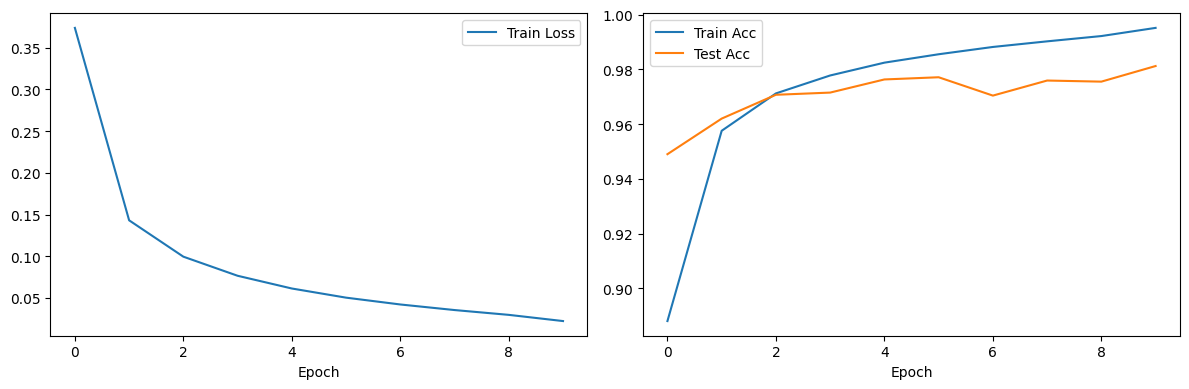

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time  # 加入时间模块

# 1. 数据加载
def load_data_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)
    return (
        DataLoader(train_data, batch_size, shuffle=True, num_workers=2),
        DataLoader(test_data, batch_size, shuffle=False, num_workers=2)
    )

# 2. 定义模型
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        self._init_weights()

    def _init_weights(self):
        def init(m):
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        self.net.apply(init)

    def forward(self, X):
        return self.net(X)

# 3. 训练函数（加入时间统计）
def train_model(net, train_iter, test_iter, num_epochs=10, lr=0.25):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    train_loss_list, train_acc_list, test_acc_list = [], [], []

    print("开始训练...")
    start_time = time.time()  # 训练开始计时

    for epoch in range(num_epochs):
        net.train()
        total_loss, total_correct = 0, 0

        for X, y in train_iter:
            optimizer.zero_grad()
            output = net(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (output.argmax(1) == y).sum().item()

        train_loss = total_loss / len(train_iter)
        train_acc = total_correct / len(train_iter.dataset)

        net.eval()
        test_correct = 0
        with torch.no_grad():
            for X, y in test_iter:
                test_correct += (net(X).argmax(1) == y).sum().item()
        test_acc = test_correct / len(test_iter.dataset)

        scheduler.step(test_acc)
        current_lr = scheduler.optimizer.param_groups[0]['lr']

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | '
              f'Test Acc: {test_acc:.3f} | LR: {current_lr:.5f}')

    end_time = time.time()  # 训练结束
    elapsed = end_time - start_time
    print(f"\n训练总耗时：{elapsed:.2f} 秒（约 {elapsed / 60:.2f} 分钟）")

    # 画图
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 4. 主程序入口
if __name__ == '__main__':
    torch.manual_seed(42)

    batch_size = 256
    num_epochs = 10
    lr = 0.25

    train_iter, test_iter = load_data_mnist(batch_size)
    model = SimpleNN()
    train_model(model, train_iter, test_iter, num_epochs, lr)
